In [1]:
from obspy import read
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Ruta al archivo .mseed
data_directory = '../../data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1975-04-12HR00_evid00191.mseed'
mseed_file = f'{data_directory}'

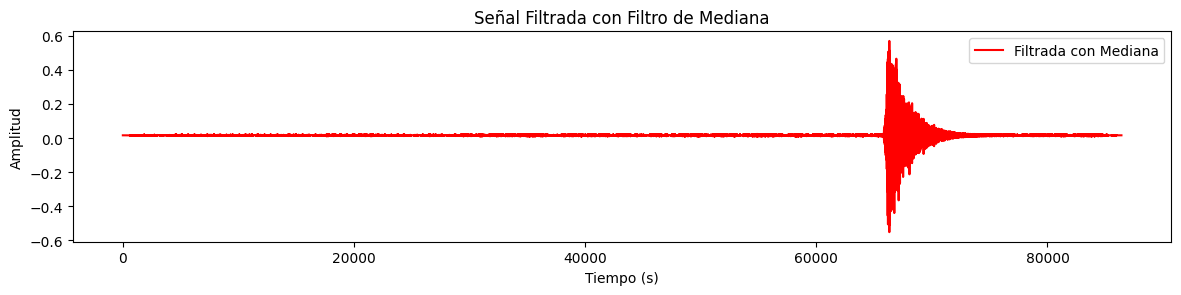

In [2]:
from scipy.signal import medfilt, savgol_filter
import matplotlib.pyplot as plt
import numpy as np
from obspy import read

# Leer el archivo mseed
st = read(mseed_file)
tr = st[0].copy()  # Obtener la primera traza

# Aplicar el filtro de banda
minfreq = 0.5
tr.filter('highpass', freq=minfreq)

# Obtener datos de la traza filtrada
tr_times = tr.times()
tr_data = tr.data

# Normalización Min-Max
min_val = np.min(tr_data)
max_val = np.max(tr_data)
tr_data_minmax = 2 * (tr_data - min_val) / (max_val - min_val) - 1  # Escalado entre -1 y 1

# 1. Aplicar un Filtro de Mediana
tr_data_median_filtered = medfilt(tr_data_minmax, kernel_size=5) 

# Visualizar las señales
plt.figure(figsize=(12, 8))

# Señal Filtrada con Mediana
plt.subplot(3, 1,1)
plt.plot(tr_times, tr_data_median_filtered, 'r-', label='Filtrada con Mediana')
plt.title('Señal Filtrada con Filtro de Mediana')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.savefig('mediana.png')
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
import noisereduce as nr
sample_rate = 1 / (tr_times[1] - tr_times[0])  # Calcular tasa de muestreo
signal_cleaned = nr.reduce_noise(y=tr_data_median_filtered, sr=sample_rate, time_mask_smooth_ms=40000)

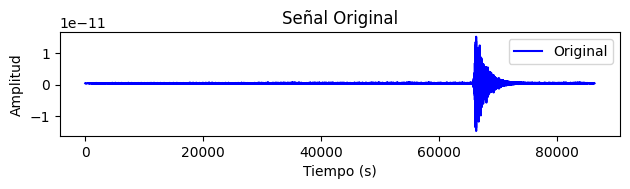

In [4]:
plt.subplot(3, 1, 1)
plt.plot(tr_times, signal_cleaned , 'b-', label='Original')
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()

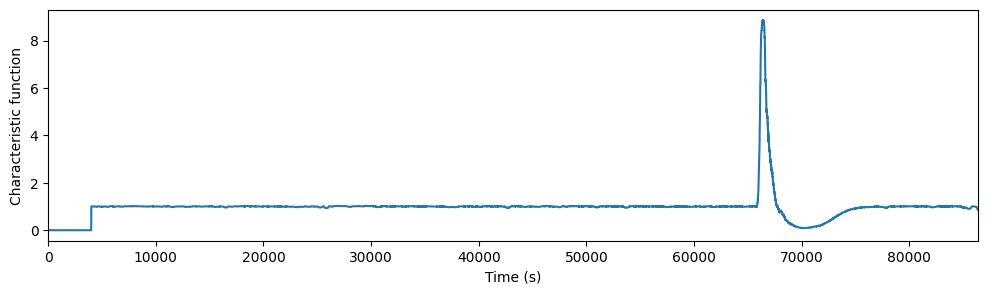

In [16]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 400
lta_len = 4000

# Run Obspy's STA/LTA to obtain a characteristic function
cft = classic_sta_lta(signal_cleaned, int(sta_len * df), int(lta_len * df))

# Definir el tiempo mínimo de duración de los eventos (en segundos)
min_duration = 420 # Puedes ajustarlo según tus necesidades

# Convertir el tiempo mínimo de duración a muestras
min_duration_samples = int(min_duration * df)
# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')
plt.savefig('caracteristica.png')

Iteración 0: Probando con thr_on=10, thr_off=1
Iteración 1: Probando con thr_on=6, thr_off=1
Se encontraron eventos que cumplen la condición en la iteración 1 con thr_on=6 y thr_off=1.


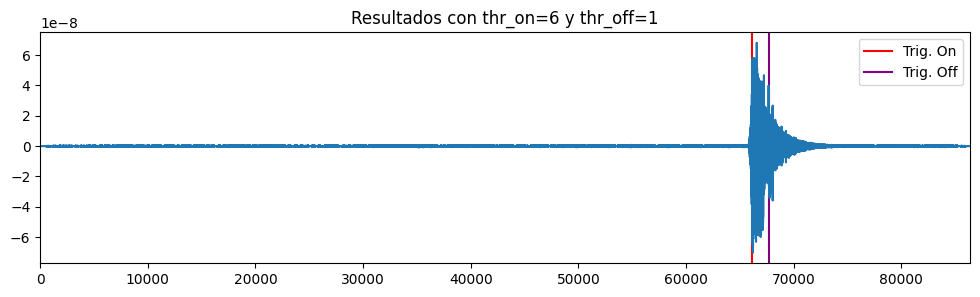

In [55]:
import numpy as np
import matplotlib.pyplot as plt

l_threshold_on = [10, 6, 5, 4, 1.8, 1.5, 1.1]  # Lista de umbrales de activación
l_threshold_off = [1, 1, 1, 1, 1, 1, 1]  # Lista de umbrales de desactivación

filtered_on_off = []  # Inicializar la lista que almacenará los eventos filtrados
idx = 0  # Inicializar el índice para las listas de umbrales

# Bucle while que se ejecuta hasta que se encuentre una lista no vacía de eventos
while len(filtered_on_off) == 0 and idx < len(l_threshold_on):
    thr_on = l_threshold_on[idx]  # Obtener el umbral de activación actual
    thr_off = l_threshold_off[idx]  # Obtener el umbral de desactivación actual
    
    print(f"Iteración {idx}: Probando con thr_on={thr_on}, thr_off={thr_off}")
    
    # Obtener los triggers usando los umbrales actuales
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))
    
    # Filtrar los eventos que duran menos que el tiempo mínimo
    filtered_on_off = []
    for triggers in on_off:
        if (triggers[1] - triggers[0]) >= min_duration_samples:
            filtered_on_off.append(triggers)
    
    # Convertir la lista filtrada de nuevo a un array de NumPy
    filtered_on_off = np.array(filtered_on_off)

    # Incrementar el índice para probar el siguiente conjunto de umbrales en caso de que no se haya encontrado ningún evento
    idx += 1

# Si se han encontrado eventos, se grafica
if len(filtered_on_off) > 0:
    print(f"Se encontraron eventos que cumplen la condición en la iteración {idx-1} con thr_on={l_threshold_on[idx-1]} y thr_off={l_threshold_off[idx-1]}.")

    # Plot on and off triggers (solo los filtrados)
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    
    for i in np.arange(0, len(filtered_on_off)):
        triggers = filtered_on_off[i]
        ax.axvline(x=tr_times[triggers[0]], color='red', label='Trig. On' if i == 0 else "")
        ax.axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off' if i == 0 else "")
    
    # Plot seismogram
    ax.plot(tr_times, tr_data)
    ax.set_xlim([min(tr_times), max(tr_times)])
    
    # Manejar leyenda sin duplicados
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    plt.title(f"Resultados con thr_on={l_threshold_on[idx-1]} y thr_off={l_threshold_off[idx-1]}")
    plt.show()
else:
    print("No se encontraron eventos que cumplan la duración mínima en ninguno de los umbrales.")

In [56]:
filtered_on_off

array([[438327, 448615]], dtype=int64)

In [57]:
import os
from dotenv import load_dotenv

load_dotenv()  # Load environment variables from .env

gemini_api_key = os.getenv("API_KEY")

In [58]:
import google.generativeai as genai
import os

genai.configure(api_key=gemini_api_key)

In [59]:
# Entrenamiento de contextos
train_file = genai.upload_file(path="./contextos/contexto_evid00002.png",
                            display_name="grafica1")
train_file2 = genai.upload_file(path="./contextos/contexto_evid00003.png",
                            display_name="grafica2")
train_file3 = genai.upload_file(path="./contextos/contexto_evid00004.png",
                            display_name="grafica1")
train_file4 = genai.upload_file(path="./contextos/contexto_evid00006.png",
                            display_name="grafica2")
train_file5 = genai.upload_file(path="./contextos/contexto_evid00007.png",
                            display_name="grafica1")
train_file6 = genai.upload_file(path="./contextos/contexto_evid00008.png",
                            display_name="grafica2")
train_file7 = genai.upload_file(path="./contextos/contexto_evid00009.png",
                            display_name="grafica1")
train_file8 = genai.upload_file(path="./contextos/contexto_evid00010.png",
                            display_name="grafica2")
train_file9 = genai.upload_file(path="./contextos/contexto_evid00013.png",
                            display_name="grafica1")
train_file10 = genai.upload_file(path="./contextos/contexto_evid00014.png",
                            display_name="grafica2")
train_file11 = genai.upload_file(path="./contextos/contexto_evid00015.png",
                            display_name="grafica1")
train_file12 = genai.upload_file(path="./contextos/contexto_evid00017.png",
                            display_name="grafica2")
train_file13 = genai.upload_file(path="./contextos/contexto_evid00019.png",
                            display_name="grafica1")
train_file14 = genai.upload_file(path="./contextos/contexto_evid00021.png",
                            display_name="grafica2")
train_file15 = genai.upload_file(path="./contextos/contexto_evid00022.png",
                            display_name="grafica1")
train_file16 = genai.upload_file(path="./contextos/contexto_evid00023.png",
                            display_name="grafica2")
train_file17 = genai.upload_file(path="./contextos/contexto_evid00024.png",
                            display_name="grafica1")
train_file18 = genai.upload_file(path="./contextos/contexto_evid00026.png",
                            display_name="grafica2")
train_file19 = genai.upload_file(path="./contextos/contexto_evid00028.png",
                            display_name="grafica1")
train_file20 = genai.upload_file(path="./contextos/contexto_evid00029.png",
                            display_name="grafica2")
train_file21 = genai.upload_file(path="./contextos/contexto_evid00030.png",
                            display_name="grafica1")
train_file22 = genai.upload_file(path="./contextos/contexto_evid00031.png",
                            display_name="grafica2")
train_file23 = genai.upload_file(path="./contextos/contexto_evid00033.png",
                            display_name="grafica1")
train_file24 = genai.upload_file(path="./contextos/contexto_evid00034.png",
                            display_name="grafica2")
train_file25 = genai.upload_file(path="./contextos/contexto_evid00035.png",
                            display_name="grafica1")
train_file26 = genai.upload_file(path="./contextos/contexto_evid00042.png",
                            display_name="grafica2")
train_file27 = genai.upload_file(path="./contextos/contexto_evid00043.png",
                            display_name="grafica1")
train_file28 = genai.upload_file(path="./contextos/contexto_evid00044.png",
                            display_name="grafica2")
train_file29 = genai.upload_file(path="./contextos/contexto_evid00045.png",
                            display_name="grafica1")
train_file30 = genai.upload_file(path="./contextos/contexto_evid00046.png",
                            display_name="grafica2")
train_file31 = genai.upload_file(path="./contextos/contexto_evid00049.png",
                            display_name="grafica1")
train_file32 = genai.upload_file(path="./contextos/contexto_evid00052.png",
                            display_name="grafica2")
train_file33 = genai.upload_file(path="./contextos/contexto_evid00055.png",
                            display_name="grafica1")
train_file34 = genai.upload_file(path="./contextos/contexto_evid00067.png",
                            display_name="grafica2")
train_file35 = genai.upload_file(path="./contextos/contexto_evid00070.png",
                            display_name="grafica1")
train_file36 = genai.upload_file(path="./contextos/contexto_evid00071.png",
                            display_name="grafica2")
train_file37 = genai.upload_file(path="./contextos/contexto_evid00083.png",
                            display_name="grafica1")
train_file38 = genai.upload_file(path="./contextos/contexto_evid00084.png",
                            display_name="grafica2")
train_file39 = genai.upload_file(path="./contextos/contexto_evid00088.png",
                            display_name="grafica1")
train_file40 = genai.upload_file(path="./contextos/contexto_evid00091.png",
                            display_name="grafica2")
train_file41 = genai.upload_file(path="./contextos/contexto_evid00093.png",
                            display_name="grafica1")
train_file42 = genai.upload_file(path="./contextos/contexto_evid00094.png",
                            display_name="grafica2")
train_file43 = genai.upload_file(path="./contextos/contexto_evid00097.png",
                            display_name="grafica2")
train_file44 = genai.upload_file(path="./contextos/contexto_evid00104.png",
                            display_name="grafica1")
train_file45 = genai.upload_file(path="./contextos/contexto_evid00107.png",
                            display_name="grafica2")
train_file46 = genai.upload_file(path="./contextos/contexto_evid00109.png",
                            display_name="grafica1")
train_file47 = genai.upload_file(path="./contextos/contexto_evid00112.png",
                            display_name="grafica2")
train_file48 = genai.upload_file(path="./contextos/contexto_evid00113.png",
                            display_name="grafica1")
train_file49 = genai.upload_file(path="./contextos/contexto_evid00117.png",
                            display_name="grafica2")
train_file50 = genai.upload_file(path="./contextos/contexto_evid00120.png",
                            display_name="grafica1")
train_file51 = genai.upload_file(path="./contextos/contexto_evid00121.png",
                            display_name="grafica2")
train_file52 = genai.upload_file(path="./contextos/contexto_evid00127.png",
                            display_name="grafica2")
train_file53 = genai.upload_file(path="./contextos/contexto_evid00136.png",
                            display_name="grafica1")
train_file54 = genai.upload_file(path="./contextos/contexto_evid00137.png",
                            display_name="grafica2")
train_file55 = genai.upload_file(path="./contextos/contexto_evid00138.png",
                            display_name="grafica1")
train_file56 = genai.upload_file(path="./contextos/contexto_evid00140.png",
                            display_name="grafica2")
train_file57 = genai.upload_file(path="./contextos/contexto_evid00141.png",
                            display_name="grafica1")
train_file58 = genai.upload_file(path="./contextos/contexto_evid00142.png",
                            display_name="grafica2")
train_file59 = genai.upload_file(path="./contextos/contextomars_evid00005.png",
                            display_name="grafica1")
train_file60 = genai.upload_file(path="./contextos/contextomars_evid00006.png",
                            display_name="grafica2")

DefaultCredentialsError: 
  No API_KEY or ADC found. Please either:
    - Set the `GOOGLE_API_KEY` environment variable.
    - Manually pass the key with `genai.configure(api_key=my_api_key)`.
    - Or set up Application Default Credentials, see https://ai.google.dev/gemini-api/docs/oauth for more information.

In [ ]:
#Entrenamiento de errores con datos no etiquetados

In [54]:
sample_file2 = genai.upload_file(path="./grafica_analisis.png",
                            display_name="grafica")

In [43]:
model = genai.GenerativeModel("gemini-1.5-pro")
chat = model.start_chat(
    history=[
        {"role": "user", "parts": f"{train_file} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file2} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file3} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file4} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file5} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"2"},
        {"role": "user", "parts": f"{train_file6} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},  
        {"role": "user", "parts": f"{train_file7} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file8} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"2"},
        {"role": "user", "parts": f"{train_file9} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},  
        {"role": "user", "parts": f"{train_file10} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file11} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file12} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file13} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file14} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file15} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file16} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file17} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file18} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},  
        {"role": "user", "parts": f"{train_file19} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file20} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file21} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},  
        {"role": "user", "parts": f"{train_file22} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"2"},
        {"role": "user", "parts": f"{train_file23} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file24} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},  
        {"role": "user", "parts": f"{train_file25} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file26} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"2"},
        {"role": "user", "parts": f"{train_file27} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file28} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file29} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file30} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},  
        {"role": "user", "parts": f"{train_file31} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file32} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file33} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},  
        {"role": "user", "parts": f"{train_file34} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"2"},
        {"role": "user", "parts": f"{train_file35} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file36} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file37} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"2"},
        {"role": "user", "parts": f"{train_file38} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file39} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file40} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file41} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file42} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},  
        {"role": "user", "parts": f"{train_file43} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file44} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file45} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"2"},  
        {"role": "user", "parts": f"{train_file46} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file47} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file48} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},  
        {"role": "user", "parts": f"{train_file49} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"2"},
        {"role": "user", "parts": f"{train_file50} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file51} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file52} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file53} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file54} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},  
        {"role": "user", "parts": f"{train_file55} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file56} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file57} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},  
        {"role": "user", "parts": f"{train_file58} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file59} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},
        {"role": "user", "parts": f"{train_file60} Cuantos sismos hay en la grafica? sabiendo que los sismos son las señales dentro de los cuadros azules (solo puedes decir numeros)"},
        {"role": "model", "parts": f"1"},           
    ]
)

In [55]:
response = chat.send_message([sample_file2,"cuantos sismos se pueden visualizar en esta grafica?"])
print(response.text)

2



In [56]:
l_STA=[60,100,400,400,400,400]
l_LTA=[1200,800,1000,2000,6000,8000]
print(len(l_STA))
print(len(l_STA))

6
6


In [117]:
model2 = genai.GenerativeModel("gemini-1.5-pro")
chat2 = model2.start_chat(
    history=[
        {"role":"user","parts": "Se tienen las siguientes listas de STA y LTA: [20,60,100,400,400,400,400] y [40,1200,800,1000,6000,2000,8000]respectivamente recuerda que son listas paralelas si se toma un valor de STA se debe tomar el valor de LTA en la misma posición de la lista"},
        {"role": "model", "parts": "Entiendo que se tienen las siguientes listas de STA y LTA: [20,60,100,400,400,400,400] y [40,1200,800,1000,6000,2000,8000]respectivamente"},
        {"role":"user","parts": "Dame alguna tupla de los valore de las listas de STA y LTA"},
        {"role": "model", "parts": "(20,40)"},
        {"role":"user","parts": "Dame alguna tupla de los valore de las listas de STA y LTA"},
        {"role": "model", "parts": "(60,1200)"},
        {"role":"user","parts": "Si se terminar los valores de las tuplas puedes volver a empezar desde el inicio(no te olvides de iniciar con (60,1200))"},
        {"role": "model", "parts": "(60,1200)"},
        {"role":"user","parts": "Si se terminar los valores de las tuplas puedes volver a empezar desde el inicio(no digas nada más que la tupla)"},
        {"role": "model", "parts": "(60,1200)"},
    ]
)

In [128]:
response = chat2.send_message("Dame alguna tupla de los valore de las listas de STA y LTA")
print(response.text)

(400, 8000)



